# Preprocessing and Modeling

In [1]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LassoCV, Ridge, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, VarianceThreshold, f_regression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

sns.set_style('darkgrid')
sns.set_palette(palette='colorblind')
np.random.seed(44)
%matplotlib inline

In [2]:
ames = pd.read_csv('../data/train_clean.csv', index_col='Id')

We create a binary column for every categorical column in order to feed it into our model.

In [3]:
ames_dummies = pd.get_dummies(data=ames)

## Model Prep

In [4]:
X = ames_dummies.drop('saleprice', axis = 1)
y = ames_dummies['saleprice']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=44)

## Modeling

### Baseline Model

In [6]:
np.mean(y_train)

180697.30658838878

This serves as our baseline model. We assume a house’s sale price will be $180,697.31 without taking into account the features and how they contribute differently. The y-intercept of our models should resemble this value.

### Multiple Linear Regression (MLR)

The MLR model finds the line of best fit that minimizes our error - the difference between predicted values and observed values. It assumes:
    -  Linearity between our X features and `sale price` (Y)
    -  Independence of errors
    -  Normality of errors
    -  Equality of Variances
    -  Independence between our independent X features
    
** Reason for choosing model: ** From our baseline model, where the `sale price` is simply the average of all `sale price`, we go slightly more complex with a MLR model. We know that collinearity exists between our features, which does not comply with the assumptions. Even so, it'll be helpful to see how well a MLR models the data and then improve from there.

In [7]:
lr_pipe = Pipeline([
    ('var_thresh', VarianceThreshold(.01)),
    ('ss', StandardScaler()),
    ('kbest', SelectKBest(f_regression, k=100)),
    ('lr', LinearRegression())
])

-  We sequentially apply transforms using `Pipeline`:

    1. **Variance Threshold**: Any features with a variance threshold less than `.01` will be dropped from our model. These features have low variance and will have little contribution. A low threshold is set because more feature selection will take place (step 3).
    2. **Standard Scalar**: The features are then standardized to display normal distribution. They're scaled to prevent any one with a higher magnitude to dominate others.  
    3. **SelectKBest**: Features are scored using f-regression and the top 100 are selected. Number of top features, `k` was arbitrarily chosen and the most optimal value will be determined with Grid Search later.
    4. **Linear Regression**: We're creating a MLR model and it's instantiated here. 

In [8]:
lr_pipe.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('var_thresh', VarianceThreshold(threshold=0.01)), ('ss', StandardScaler(copy=True, with_mean=True, with_std=True)), ('kbest', SelectKBest(k=100, score_func=<function f_regression at 0x117ca0a60>)), ('lr', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

-  The MLR model is fitted to our training set. 

#### ${R^2}$ Scores

In [9]:
lr_pipe.score(X_train, y_train)

0.9131418224513435

-  The model scored high on the training set, with an $R^{2}$ score of `.9131`. 
-  91.31% of the variance in the data (`y_train`) is explained by our model, relative to the mean (`180697.31`).

In [10]:
lr_pipe.score(X_test, y_test)

-3.1790332806969336e+22

-  The model scored worse on the testing set, with an $R^{2}$ score of $-3.17 e^{+22}$.
-  The score is worse than our baseline model score of 0.

#### RMSE

In [11]:
lr_rmse = mean_squared_error(y_test, lr_pipe.predict(X_test)) ** 0.5
lr_rmse

1.497012455288918e+16

-  The RMSE is significantly greater than our baseline model of `180697.31`.

#### Takeaways
-  We expected the MLR model to perform better than our baseline, but this was not the case. 
    -  Our model's $R^{2}$ on the testing set and the RMSE were worse than our baseline model's score.
-  The model assumptions were not met, with multicollinearity existing between features that were not removed. This can help explain why our model broke. 
-  We will move onto regularization to fix the model and make sure the weight of our coefficients are due to signal rather than noise.

### Lasso

Lasso, a type of feature selection, penalizes large coefficients due to noise and reduces them to zero. It will have little effect on large coefficients that are actually due to signal. 

** Reason for Choosing Model: ** We have a large number of features and want to aggressively remove features that do not contribute to our model entirely. This will address the issue we encountered in MLR, where, even with some feature selection, the model broke. It will also allow for easier interpretability.

In [12]:
lasso_pipe = Pipeline([
    ('var_thresh', VarianceThreshold(.01)),
    ('ss', StandardScaler()),
    ('kbest', SelectKBest(f_regression, k=100)),
    ('lasso', LassoCV())
])

-  Similar to before, we sequentially apply transforms using `Pipeline` and the same parameters:

    1. **Variance Threshold**
    2. **Standard Scalar**: This is required because the size of a coefficient depends on the scale of the independent variable. Regularization, in turn, penalizes the size of these coefficients.
    3. **SelectKBest**
    4. **Lasso**: We're applying a Lasso penalty and it's instantiated here. 

In [13]:
lasso_pipe.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('var_thresh', VarianceThreshold(threshold=0.01)), ('ss', StandardScaler(copy=True, with_mean=True, with_std=True)), ('kbest', SelectKBest(k=100, score_func=<function f_regression at 0x117ca0a60>)), ('lasso', LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False))])

-  Lasso is fitted to our training set.

#### $R^{2}$ Scores

In [14]:
lasso_pipe.score(X_train, y_train)

0.9147634908349038

-  The model scored high on the training set, with an $R^{2}$ score of `.9148`.
-  91.48% of the variance in the data (`y_train`) is explained by our model, relative to the mean (`180697.31`).

In [15]:
lasso_pipe.score(X_test, y_test)

0.9036873458386654

-  The model scored high on the testing set as well, with an $R^{2}$ score of `.9037`.
-  90.37% of the variance in the data (`y_test`) is explained by our model, relative ot the mean (`180697.31`).

#### RMSE

In [16]:
lasso_rmse = mean_squared_error(y_test, lasso_pipe.predict(X_test)) ** 0.5
lasso_rmse

26056.70835640306

-  The model has a RMSE of `26056.71`.
-  The predicted sale price will typically be lower or higher than the true sale price by `$26056.71`.

#### Takeaways
-  The model performed well on both our training and testing set. 
-  Our scores are relatively close to each other, with the $R^{2}$ score on our training set being higher by only `.01`. 
-  As expected, we have a better RMSE than our baseline model.
-  We will try another type of regularization, Ridge and compare the scores to see which model performs better.

### Ridge

Similar to Lasso, Ridge penalizes large coefficients due to noise and will have little effect on large coefficients that are actually due to signal. However, the magnititudes of the coefficients are reduced, not zeroed out. 

** Reason for Choosing Model: ** Ridge will be helpful in addresing the multicollinearity issue we're currently experiencing. It reduces model complexity by shrinking the coefficients, but does not remove them entirely.

In [17]:
ridge_pipe = Pipeline([
    ('var_thresh', VarianceThreshold(.01)),
    ('ss', StandardScaler()),
    ('kbest', SelectKBest(f_regression, k=100)),
    ('ridge', Ridge())
])

-  Again, we use `Pipeline`:

    1. **Variance Threshold**
    2. **Standard Scalar**
    3. **SelectKBest**
    4. **Ridge**: We're applying a Ridge penalty and it's instantiated here. 

In [18]:
ridge_pipe.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('var_thresh', VarianceThreshold(threshold=0.01)), ('ss', StandardScaler(copy=True, with_mean=True, with_std=True)), ('kbest', SelectKBest(k=100, score_func=<function f_regression at 0x117ca0a60>)), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))])

-  Ridge is fitted to our training set.

#### $R^{2}$ Scores

In [19]:
ridge_pipe.score(X_train, y_train)

0.918620216024707

-  The model scored high on the training set, with an $R^{2}$score of `.9186`.
-  91.86% of the variance in the data (`y_train`) is explained by our model, relative to the mean (`180697.31`).

In [20]:
ridge_pipe.score(X_test, y_test)

0.9068277386207624

-  The model scored high on the testing set as well, with an $R^{2}$ score of `.9068`.
-  90.68% of the variance in the data (`y_test`) is explained by our model, relative ot the mean (`180697.31`).

#### RMSE

In [21]:
ridge_rmse = mean_squared_error(y_test, ridge_pipe.predict(X_test)) ** 0.5
ridge_rmse

25628.38235327715

-  The model has a RMSE of `25628.38`.
-  The predicted sale price will typically be lower or higher than the true sale price by `$25628.38`.

#### Takeaways
-  The outcome between Ridge and Lasso are similar, with the $R^{2}$ score between the training and testing set only differing by `.01` as well.
-  Ridge performed slightly better than Lasso. The RMSE is lower by `428`. 
-  We will move forward with this model and use Grid Search to find the most optimal parameters.

In [22]:
params = {
    'var_thresh__threshold': [.001, .01, .03],
    'kbest__k': [101, 103, 105],
    'ridge__alpha': np.logspace(-3, 3, 10)
}

-  A dictionary is set, with the parameters and list of values to search over specified.

In [23]:
gs = GridSearchCV(ridge_pipe, params, cv=5)

In [24]:
gs.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('var_thresh', VarianceThreshold(threshold=0.01)), ('ss', StandardScaler(copy=True, with_mean=True, with_std=True)), ('kbest', SelectKBest(k=100, score_func=<function f_regression at 0x117ca0a60>)), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'var_thresh__threshold': [0.001, 0.01, 0.03], 'kbest__k': [101, 103, 105], 'ridge__alpha': array([1.00000e-03, 4.64159e-03, 2.15443e-02, 1.00000e-01, 4.64159e-01,
       2.15443e+00, 1.00000e+01, 4.64159e+01, 2.15443e+02, 1.00000e+03])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [25]:
gs.score(X_train, y_train)

0.9242611564867057

-  92.43% of the variance in the data (`y_train`) is explained by our model, relative to the mean (`180697.31`).
-  The $R^{2}$ score improved slightly, increaseing from 91.86% to 92.43%.

In [26]:
gs.score(X_test, y_test)

0.9105664678700035

-  91.06% of the variance in the data (`y_test`) is explained by our model, relative to the mean (`180697.31`).
-  The $R^{2}$ score improved slightly, increasing from 90.68% to 91.06%.

#### Best Parameters

In [27]:
gs.best_params_

{'kbest__k': 105,
 'ridge__alpha': 46.41588833612773,
 'var_thresh__threshold': 0.03}

#### Beta Coefficients

In [28]:
ridge_intercept = ridge_pipe.named_steps['ridge'].intercept_
ridge_intercept

180697.30658838875

-  `y-intercept = 180697.31`
-  When all the features (X) are zero, the sale price is `$180697.31`.
    -  This can be due to no property being built yet. 
    -  The sale price may only represent the price of the land, with no features included.

In [29]:
ridge_columns = X.columns
ridge_columns = ridge_columns[gs.best_estimator_.named_steps['var_thresh'].get_support()]
ridge_columns = ridge_columns[gs.best_estimator_.named_steps['kbest'].get_support()]

In [30]:
ridge_betas = pd.DataFrame(gs.best_estimator_.named_steps['ridge'].coef_, index=ridge_columns)

In [31]:
ridge_betas.columns = ['weights']

In [32]:
ridge_betas['abs_w'] = ridge_betas['weights'].abs()

In [33]:
ridge_betas.shape[0]

105

-  The model has a total of 105 features.
-  We know this because the best value for `k` is `105` when we did Grid Search.

In [34]:
ridge_betas.sort_values(by='abs_w', ascending=False)[['weights']].head()

,weights
gr_liv_area,14333.209867
overall_qual,10624.333213
2nd_flr_sf,10604.644218
total_bsmt_sf,9824.733990
1st_flr_sf,9386.175575


-  The top 5 heaviest predictors of our model has a positive relationship with `saleprice`.
-  Most features are already pre-determined and will be difficult for homeowners to change, unless major renovations take place.
-  Only `overall_qual` can be easily improved upon.

#### Visualize Beta Coefficients

In [35]:
ridge_weights = ridge_betas.sort_values(by='abs_w', ascending=False)['weights'].head(10)

In [36]:
ridge_labels = ridge_weights.index

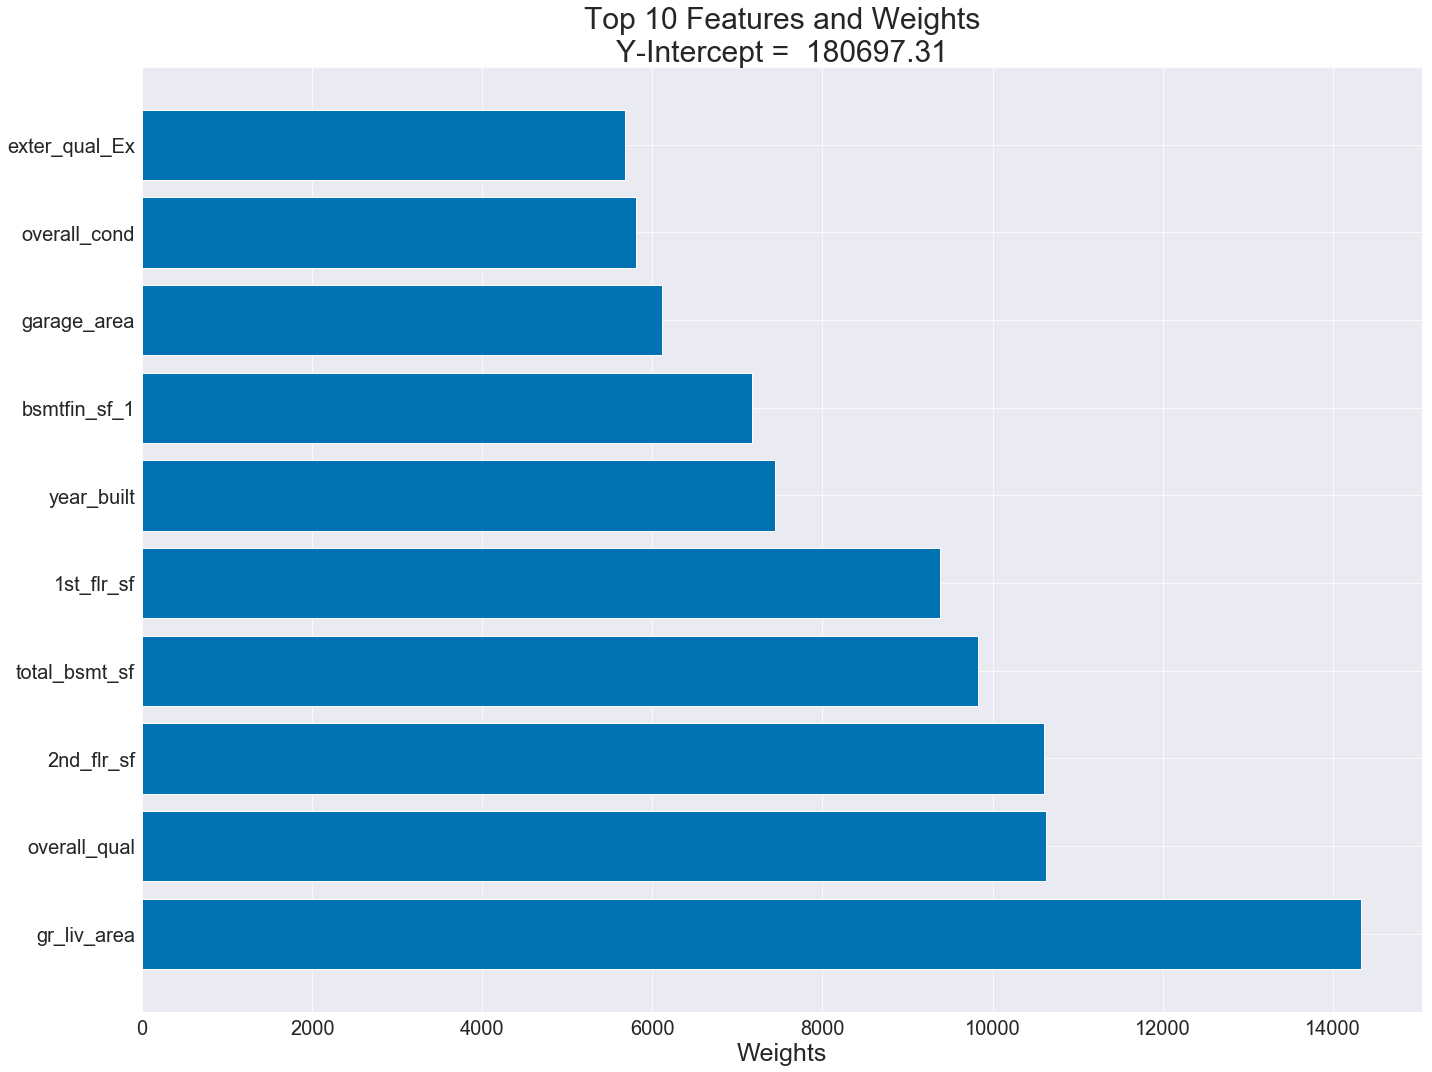

In [37]:
plt.figure(figsize=(20, 15))
plt.barh(ridge_labels, ridge_weights)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Weights', fontsize=25)
plt.title(f'Top 10 Features and Weights\nY-Intercept = {ridge_intercept: .2f}', fontsize=30)
plt.tight_layout()

#### Top 10 Predictors

| feature | weight |
| --- | --- |
| gr_liv_area | 1.43e+04 |
| overall_qual | 1.06e+04 |
| 2nd_flr_sf | 1.06e+04 |
| total_bsmt_sf | 9.82e+03 |
| 1st_flr_sf | 9.39e+03 |
| year_built | 7.44e+03 |
| bsmtfin_sf_1 | 7.17e+03 |
| garage_area | 6.11e+03 |
| overall_cond | 5.80e+03 |
| exter_qual_Ex | 5.67e+03 |

-  The top 10 predictors of our model has a positive relationship with `saleprice`.
-  `gr_liv_area` (above ground living area sqft.) carries the most weight. With a 1 unit increase in `gr_liv_area`, the `saleprice` increases by `$14300`.
-  As noted before, most of the features is square feet, making it hard to improve.
-  `overall_qual`, `overall_cond` and `exter_qual_Ex` are features that carry the most weight and relatively easier to improve.

#### Visualize Errors

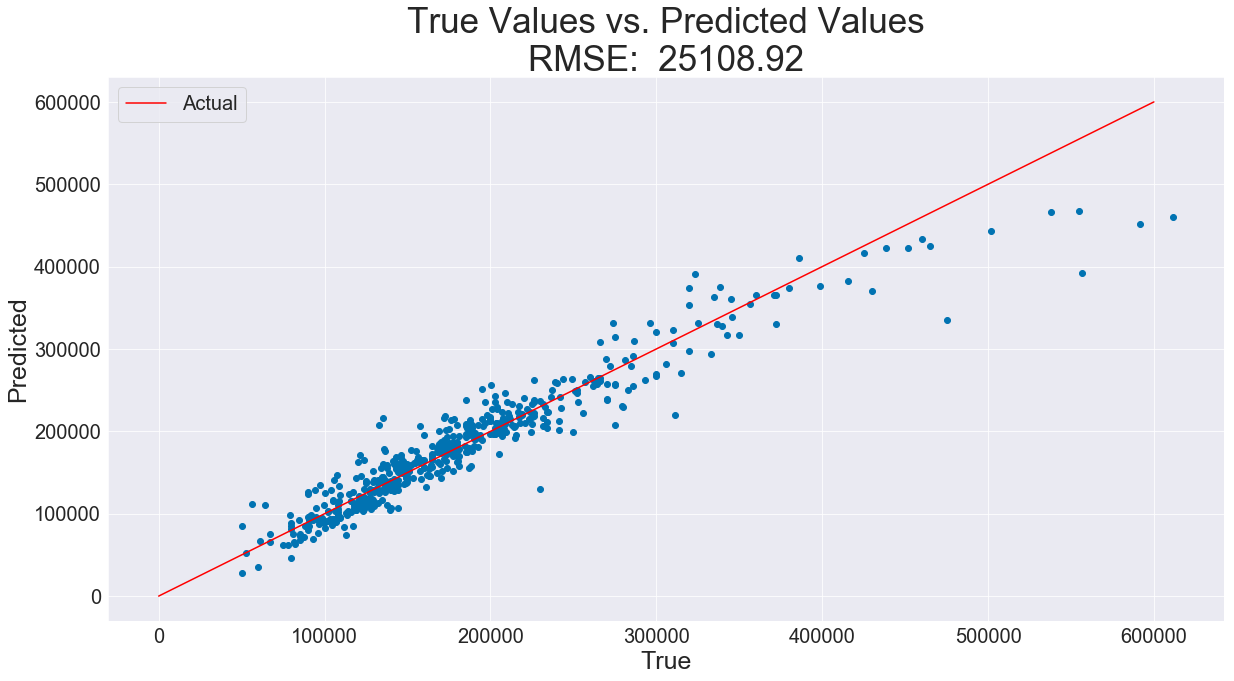

In [38]:
plt.figure(figsize=(20, 10))
plt.title(f'True Values vs. Predicted Values\nRMSE: {mean_squared_error(y_test, gs.predict(X_test)) ** 0.5: .2f}', fontsize=35)
plt.scatter(y_test, gs.predict(X_test))
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Predicted', fontsize=25)
plt.xlabel('True', fontsize=25)
plt.plot([0, 600000], [0, 600000], color='r')
plt.legend(['Actual'], fontsize=20);

-  Plots the relationship between my predicted and true values.
-  The red line represents the true values.
-  The distance between each data point and the line represents the error.
-  My model is bad at predicting the sale price for houses, where the true price is greater than `$400000`.
-  My model has a RMSE score of `25108.92`.
    -  The predicted sale price will typically be lower or higher than the true sale price by `$25108.92`.

### Pickle Columns and Model for Future Predictions

In [39]:
with open('../assets/columns.pkl', 'wb+') as f:
    pickle.dump(X.columns, f)

In [40]:
with open('../assets/ridge.pkl', 'wb+') as f:
    pickle.dump(gs, f)

### Recommendations

-  From the top 10 predictors, it’ll be best to focus on improving:
    -  overall quality
    -  overall condition

-  These features contribute the most weight to increasing the sale price of a house, but does not require as much renovations and expenses as the others do.